<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Logo_UTFSM.png/250px-Logo_UTFSM.png style="float:right;height:90px">
<img src=http://carla2014.ccarla.org/img/logo_DI_UTFSM.jpg style="float:left;height:90px">
<center>
    <h1> Scientific Programming in Python  </h1>
    <h2> Actividad 8 </h2> 
</center>

<center>    
    Roberto Felipe Fuentes Zenteno - `roberto.fuentes@alumnos.usm.cl`.
</center>

In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import threading
import multiprocessing
from ipyparallel import Client

def image_plot(img):
    """
    img is an (nx,ny,3) numpy.array
    """
    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

En esta actividad realizaremos convolución de imágenes (tarea altamente paralelizable), sobre imágenes de gran tamaño y de forma paralela, utilizando bibliotecas de paralelización en Python.

En primer lugar cargamos y visualizamos la imágen a trabajar:

In [2]:
img = plt.imread('heic1608b.jpg', format='jpeg')[0:8660,:,:]
print(img.shape)

(8660, 10260, 3)


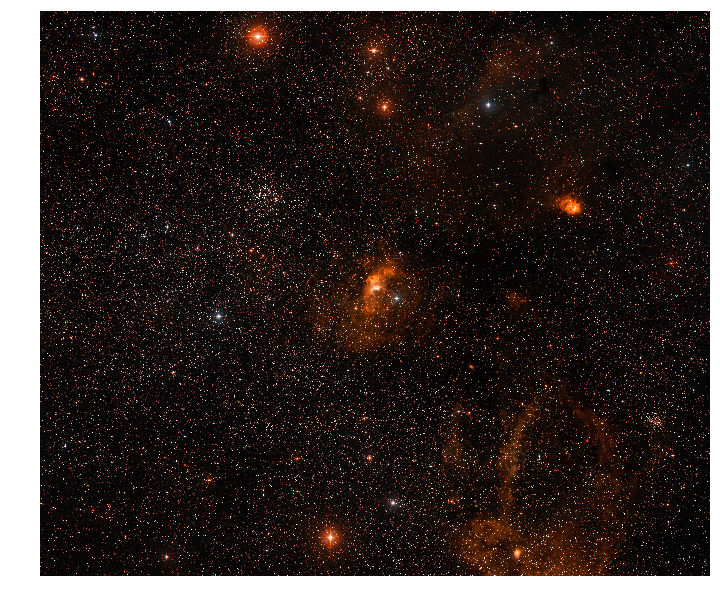

In [27]:
image_plot(img)

Lo que se desea es aplicar un filtro de _blurring_ (Gaussiano) sobre tal imágen. En este caso ocuparemos en filtro/kernel Gaussiano de `5x5` generado por la siguiente función:

In [3]:
def gaussian_kernel(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [4]:
K = gaussian_kernel((5,5))
print(K)

[[  6.96247819e-08   2.80886418e-05   2.07548550e-04   2.80886418e-05
    6.96247819e-08]
 [  2.80886418e-05   1.13317669e-02   8.37310610e-02   1.13317669e-02
    2.80886418e-05]
 [  2.07548550e-04   8.37310610e-02   6.18693507e-01   8.37310610e-02
    2.07548550e-04]
 [  2.80886418e-05   1.13317669e-02   8.37310610e-02   1.13317669e-02
    2.80886418e-05]
 [  6.96247819e-08   2.80886418e-05   2.07548550e-04   2.80886418e-05
    6.96247819e-08]]


Para ello se le solicita lo siguiente:

1. Usando `IPython.Parallel` desarrolle una solución para aplicar el filtro de convolución `K` sobre la imágen dada. Usted es libre de elegir el modo (_synchronous_ o _asynchronous_) y el modo de despacho de tareas. __Notar:__ Que la imágen tiene 3 canales (RGB) y debe aplicar el filtro independientemente en cada uno.
2. Ejecute su solución sobre la imágen y muestre el resultado.
3. Ejecute su solución anterior sobre un _pool_ de `1`, `2`, `4` y `8` _engines_ realizando un análisis de tiempo con `%timeit`. Extraiga conclusiones de los resultados obtenidos (considere las características del CPU de su computador). 

## Desarrollo

### Pregunta 1

In [19]:
rc = Client()

In [20]:
v = rc.load_balanced_view()

In [21]:
#Creamos una funcion para aplicar el filtro
def apply_filter(img):
    import numpy as np
    #inicializamos el kernel gaussiano descrito anteriormente
    K = np.array([[6.96247819e-08, 2.80886418e-05, 2.07548550e-04, 2.80886418e-05, 6.96247819e-08],
    [2.80886418e-05, 1.13317669e-02, 8.37310610e-02, 1.13317669e-02, 2.80886418e-05],
    [2.07548550e-04, 8.37310610e-02, 6.18693507e-01, 8.37310610e-02, 2.07548550e-04],
    [2.80886418e-05, 1.13317669e-02, 8.37310610e-02, 1.13317669e-02, 2.80886418e-05],
    [6.96247819e-08, 2.80886418e-05, 2.07548550e-04, 2.80886418e-05, 6.96247819e-08]])
    #Lo que haremos sera crear una lista para guardar los valores de las operaciones por fila.
    #Luego por fila, crearemos submatrices de 5x5, las que multiplicaremos por el kernel gaussiano 
    #y obtendremos un valor, guardando este en una lista. 
    list_values_filter = []
    #haremos que el for haga saltos de 5x5.
    for i in range(0,img.shape[0],5):
        
        sub_matrix = np.zeros((5,5))
        sub_row = img[i:i+5,:]
        
        for j in range(3,sub_row.shape[1]-1,5):
            sub_matrix = sub_row[:,j-3:j+2]
            list_values_filter.append((K.ravel() * sub_matrix.ravel()).sum())
            #borramos estas variables de la memoria
            del sub_matrix
            
        del sub_row
    return np.array(list_values_filter)

In [22]:
def Rebuild_image(dset,K):
    #obtenemos los tamaños de las matrices post construccion para luegos reconstruir
    shape_1 = int(img.shape[0]/5)
    shape_2 = int(img.shape[1]/5)
    #tenemos una lista con los canales a paralelizar
    channel_list = [img[:,:,0],img[:,:,1],img[:,:,2]]
    #metemos la lista de matrices a nuestra funcion, para que cada hebra aplique el kernel.
    ar = v.map(apply_filter, channel_list)
    #print(ar.result())
    #cada resultado lo remodelamos para que tenga forma de matriz
    r = ar.result()[0].reshape((shape_1, shape_2))
    g = ar.result()[1].reshape((shape_1, shape_2))
    b = ar.result()[2].reshape((shape_1, shape_2))

    #juntamos todos los canales para volver a formar la imagen
    image_reconstructed = np.zeros((r.shape[0],r.shape[1],3),'uint8')
    
    image_reconstructed[:,:,0] = r
    image_reconstructed[:,:,1] = g
    image_reconstructed[:,:,2] = b
    
    return image_reconstructed

### Pregunta 2

(1732, 2052, 3)


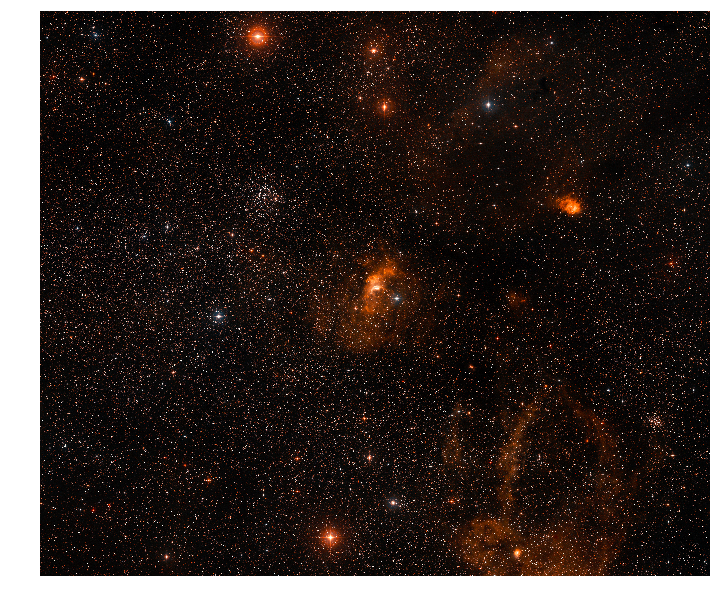

In [10]:
image = Rebuild_image(img,K)
print(image.shape)
image_plot(image)

### Pregunta 3

Primero veremos cuantos nucleos tiene nuestro pc:

In [26]:
!sysctl -n hw.physicalcpu_max

2


Al ver que solo tenemos 2 nucleos, se toma como hipotesis que solo con 1 y 2 engines se tendrá un resultado. Se prueba entonces con los distintos _engines_ del enunciado nuestro programa.

Con 1 _engine_:

In [18]:
!ipcluster start -n 1
%timeit -n 1 Rebuild_image(img,K)

1min 5s ± 17.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Con 2 _engines_:

In [23]:
!ipcluster start -n 2
%timeit -n 1 Rebuild_image(img,K)

39.7 s ± 4.01 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Probando con 4 y 8 _engines_, la función se queda estancada. Esto sucede ya que al tener solo 2 núcleos, el proceso no puede ocupar más núcleos de los que tiene, quedandose estancado. Observamos que a medida que se aumenta la cantidad de _engines_, la ejecución del programa se realiza de forma mucho mas rápida, por lo que es una gran mejora el paralelizar. Sin embargo, debemos tener en cuenta que podemos paralelizar y que no, ya que si el programa debe ejecutarse de forma lineal el paralelizar no servira de mucho.